<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/Update6_BTC_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

     |████████████████████████████████| 63 kB 316 kB/s 
     |████████████████████████████████| 6.4 MB 14.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Importing the Dataset & Exploring it

In [ ]:
# Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '2y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: BTC-USD
You entered BTC-USD, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
722,2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625,20964372926,0,0
723,2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,24324345758,0,0
724,2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,33430376883,0,0
725,2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,30049226299,0,0
726,2021-12-30,46490.605469,47879.964844,46060.312500,47178.125000,26686491018,0,0
727,2021-12-31,47169.371094,48472.527344,45819.953125,46306.445312,36974172400,0,0
728,2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,24582667004,0,0
729,2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,27951569547,0,0
730,2022-01-03,47343.542969,47510.726562,45835.964844,46458.117188,33071628362,0,0
731,2022-01-04,46505.226562,47383.644531,46063.093750,47119.191406,38110781440,0,0


In [ ]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,732.000000,732.000000,732.000000,732.000000,7.320000e+02,732.0,732.0
mean,29392.098227,30197.558610,28509.729815,29440.100246,4.010191e+10,0.0,0.0
std,19672.224101,20202.130404,19043.798836,19658.939319,2.054367e+10,0.0,0.0
min,5002.578125,5331.833984,4106.980957,4970.788086,1.225260e+10,0.0,0.0
25%,9726.798340,9901.425293,9587.468506,9732.741699,2.767645e+10,0.0,0.0
50%,30118.663086,31910.902344,28923.497070,30625.189453,3.615833e+10,0.0,0.0
75%,47780.924805,49161.133789,46678.666992,47729.456055,4.733599e+10,0.0,0.0
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [ ]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [ ]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [ ]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [ ]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [ ]:
def get_hurst_exponent(time_series, max_lag=100):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [ ]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 121, 2)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [ ]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
727,2021-12-31,46306.445312
728,2022-01-01,47686.812500
729,2022-01-02,47345.218750
730,2022-01-03,46458.117188
731,2022-01-04,47119.191406


## Creating Facebook Prophet Model

In [ ]:
m=Prophet(daily_seasonality=False)
m.fit(prophet_df)

##Forecasting

In [ ]:
periods = 30
future=m.make_future_dataframe(periods)

In [ ]:
forecast=m.predict(future)

In [ ]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-04,2792.935822,5866.814819,12044.853773,2792.935822,2792.935822,6179.570540,6179.570540,6179.570540,39.249293,39.249293,39.249293,6140.321247,6140.321247,6140.321247,0.0,0.0,0.0,8972.506362
1,2020-01-05,2814.167409,6049.792674,12574.523812,2814.167409,2814.167409,6367.805006,6367.805006,6367.805006,12.405636,12.405636,12.405636,6355.399370,6355.399370,6355.399370,0.0,0.0,0.0,9181.972415
2,2020-01-06,2835.398997,5984.239720,12410.674320,2835.398997,2835.398997,6512.177510,6512.177510,6512.177510,-13.303074,-13.303074,-13.303074,6525.480585,6525.480585,6525.480585,0.0,0.0,0.0,9347.576507
3,2020-01-07,2856.630584,6255.307476,12527.382388,2856.630584,2856.630584,6529.355583,6529.355583,6529.355583,-118.426530,-118.426530,-118.426530,6647.782112,6647.782112,6647.782112,0.0,0.0,0.0,9385.986167
4,2020-01-08,2877.862171,6453.382910,12906.415630,2877.862171,2877.862171,6791.563791,6791.563791,6791.563791,71.013614,71.013614,71.013614,6720.550177,6720.550177,6720.550177,0.0,0.0,0.0,9669.425962
5,2020-01-09,2899.093759,6404.764352,13009.227860,2899.093759,2899.093759,6716.859468,6716.859468,6716.859468,-26.237145,-26.237145,-26.237145,6743.096613,6743.096613,6743.096613,0.0,0.0,0.0,9615.953227
6,2020-01-10,2920.325346,6402.842994,12655.478266,2920.325346,2920.325346,6751.110752,6751.110752,6751.110752,35.298205,35.298205,35.298205,6715.812547,6715.812547,6715.812547,0.0,0.0,0.0,9671.436099
7,2020-01-11,2941.556933,6513.967003,12818.110477,2941.556933,2941.556933,6679.407965,6679.407965,6679.407965,39.249293,39.249293,39.249293,6640.158672,6640.158672,6640.158672,0.0,0.0,0.0,9620.964899
8,2020-01-12,2962.788521,5979.699815,12542.145596,2962.788521,2962.788521,6531.037824,6531.037824,6531.037824,12.405636,12.405636,12.405636,6518.632188,6518.632188,6518.632188,0.0,0.0,0.0,9493.826345
9,2020-01-13,2984.020108,6022.558742,12671.104745,2984.020108,2984.020108,6341.407930,6341.407930,6341.407930,-13.303074,-13.303074,-13.303074,6354.711004,6354.711004,6354.711004,0.0,0.0,0.0,9325.428038


In [ ]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

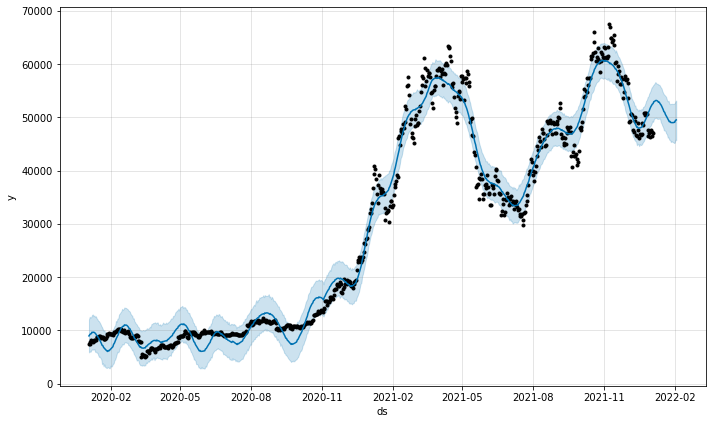

In [ ]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

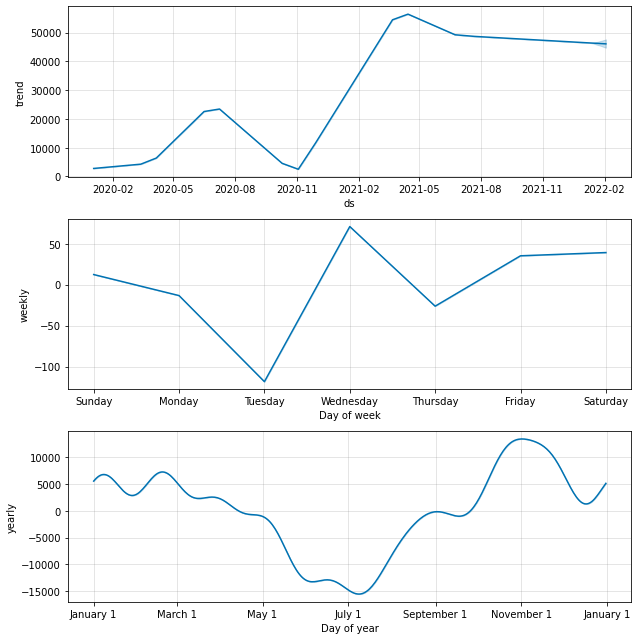

In [ ]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [ ]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>